Syntax natürlicher Sprachen, WS 2024/25

# 09 - Übung

In [564]:
import nltk
from nltk import Tree
from nltk import parse
from nltk.grammar import FeatureGrammar

In [565]:
def show_FeatTree(tree, style=0, draw=1):
    if draw:
        tree = Tree.fromstring(str(tree).replace(", ",","))
        if style: 
            display(tree)
        else: 
            tree.pretty_print(unicodelines=True)
    else: print("FOUND PARSE:\n", str(tree).replace("\n"," "))

## Aufgabe 1 - FCFG-Erweiterung (Kasus, Agreement, Subkategorisierung)

### a) Übergenerierende CFG

#### Betrachten Sie die Parsingergebnisse untenstehender Sätze mit der folgenden einfachen CFG-Grammatik und geben Sie an, welches grammatikalische Constraint jeweils verletzt ist (Kasus, Agreement, Subkategorisierung).

In [566]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> DET N
VP -> V
VP -> V NP

DET -> 'der' | 'dem' | 'den' | 'die'
N -> 'Hund' | 'Hunde' |'Hunden' |'Katze' |'Katzen'
V -> 'sieht' | 'sehen' | 'hilft' | 'helfen' | 'läuft' | 'laufen'
""")

In [567]:
pos_sent = "der Hund sieht die Katze"

In [568]:
parser = nltk.ChartParser(grammar)
trees = list(parser.parse(pos_sent.split()))
if trees: [tree.pretty_print(unicodelines=True) for tree in trees]
else: print(f"no parse found for: {sent}")

               S                
     ┌─────────┴────┐            
     │              VP          
     │         ┌────┴───┐        
     NP        │        NP      
 ┌───┴───┐     │    ┌───┴────┐   
DET      N     V   DET       N  
 │       │     │    │        │   
der     Hund sieht die     Katze



In [569]:
neg_sents = [
    "der Hund sieht",  # Subkategorisierung - sieht transitiv braucht NP
    "dem Hund sieht der Katze", # Kasusrektion - sieht braucht Akkusativ, Subjekt der Hund anstatt dem Hund
    "der Hund sehen die Katze", # Agreement - Verb und Subjekt stimmen nicht überein
]

In [570]:
parser = nltk.ChartParser(grammar)
for sent in neg_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [tree.pretty_print(unicodelines=True) for tree in trees]
    else: print(f"no parse found for: {sent}")

         S        
     ┌───┴─────┐   
     NP        VP 
 ┌───┴───┐     │   
DET      N     V  
 │       │     │   
der     Hund sieht

               S                
     ┌─────────┴────┐            
     │              VP          
     │         ┌────┴───┐        
     NP        │        NP      
 ┌───┴───┐     │    ┌───┴────┐   
DET      N     V   DET       N  
 │       │     │    │        │   
dem     Hund sieht der     Katze

               S                
     ┌─────────┴────┐            
     │              VP          
     │         ┌────┴───┐        
     NP        │        NP      
 ┌───┴───┐     │    ┌───┴────┐   
DET      N     V   DET       N  
 │       │     │    │        │   
der     Hund sehen die     Katze



### b) Fügen Sie schrittweise Constraints hinzu um diese drei Überproduktionen zu verhindern.


In [571]:
grammar = FeatureGrammar.fromstring(r"""
% start S

S[ARG=?a] -> NP[ARG=?a] VP[ARG=?a]

NP[ARG=?a] -> DET[ARG=?a] N[ARG=?a]

# VP rules with correct number agreement
VP[ARG=[NUM=?num]] -> V[SUBCAT=0, ARG=[NUM=?num]]
VP[ARG=[NUM=?num]] -> V[SUBCAT=1, OBJCASE=akk, ARG=[NUM=?num]] NP[ARG=[CASE=akk, NUM=?num]]

# Determiners with Case and Gender
DET[ARG=[NUM=sg, GEN=mask, CASE=nom]] -> 'der'
DET[ARG=[NUM=sg, GEN=mask, CASE=dat]] -> 'dem'
DET[ARG=[NUM=sg, GEN=mask, CASE=akk]] -> 'den'
DET[ARG=[NUM=sg, GEN=fem, CASE=nom]] -> 'die'
DET[ARG=[NUM=sg, GEN=fem, CASE=akk]] -> 'die'
DET[ARG=[NUM=pl, CASE=nom]] -> 'die'
DET[ARG=[NUM=pl, CASE=akk]] -> 'die'

# Nouns with Agreement
N[ARG=[NUM=sg, GEN=mask, CASE=nom]] -> 'Hund'
N[ARG=[NUM=pl, GEN=mask, CASE=nom]] -> 'Hunde'
N[ARG=[NUM=sg, GEN=fem, CASE=nom]] -> 'Katze'
N[ARG=[NUM=sg, GEN=fem, CASE=akk]] -> 'Katze'
N[ARG=[NUM=pl, GEN=fem, CASE=nom]] -> 'Katzen'

# Verbs (Intransitive - Require Subject Agreement!)
V[SUBCAT=0, ARG=[NUM=sg]] -> 'läuft'
V[SUBCAT=0, ARG=[NUM=pl]] -> 'laufen'

# Verbs (Transitive, Akkusativ)
V[SUBCAT=1, OBJCASE=akk, ARG=[NUM=sg]] -> 'sieht'
V[SUBCAT=1, OBJCASE=akk, ARG=[NUM=pl]] -> 'sehen'
""")

In [572]:
parser = nltk.FeatureChartParser(grammar)
for sent in neg_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, style=1) for tree in trees]
    else: print(f"no parse found for: {sent}")

no parse found for: der Hund sieht
no parse found for: dem Hund sieht der Katze
no parse found for: der Hund sehen die Katze


### c) Testen Sie abschließend, ob folgende Sätze weiterhin erkannt werden:

In [573]:
pos_sents = [
    "der Hund sieht die Katze", 
    "die Hunde laufen",
    "der Hund läuft"
]

In [574]:
parser = nltk.FeatureChartParser(grammar)
for sent in pos_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, draw=0) for tree in trees]
    else: print(f"no parse found for: {sent}")

FOUND PARSE:
 (S[ARG=[CASE='nom', GEN='mask', NUM='sg']]   (NP[ARG=[CASE='nom', GEN='mask', NUM='sg']]     (DET[ARG=[CASE='nom', GEN='mask', NUM='sg']] der)     (N[ARG=[CASE='nom', GEN='mask', NUM='sg']] Hund))   (VP[ARG=[NUM='sg']]     (V[ARG=[NUM='sg'], OBJCASE='akk', SUBCAT=1] sieht)     (NP[ARG=[CASE='akk', GEN='fem', NUM='sg']]       (DET[ARG=[CASE='akk', GEN='fem', NUM='sg']] die)       (N[ARG=[CASE='akk', GEN='fem', NUM='sg']] Katze))))
FOUND PARSE:
 (S[ARG=[CASE='nom', GEN='mask', NUM='pl']]   (NP[ARG=[CASE='nom', GEN='mask', NUM='pl']]     (DET[ARG=[CASE='nom', NUM='pl']] die)     (N[ARG=[CASE='nom', GEN='mask', NUM='pl']] Hunde))   (VP[ARG=[NUM='pl']] (V[ARG=[NUM='pl'], SUBCAT=0] laufen)))
FOUND PARSE:
 (S[ARG=[CASE='nom', GEN='mask', NUM='sg']]   (NP[ARG=[CASE='nom', GEN='mask', NUM='sg']]     (DET[ARG=[CASE='nom', GEN='mask', NUM='sg']] der)     (N[ARG=[CASE='nom', GEN='mask', NUM='sg']] Hund))   (VP[ARG=[NUM='sg']] (V[ARG=[NUM='sg'], SUBCAT=0] läuft)))


In [575]:
# Tracing-Beispiel
parser = nltk.FeatureChartParser(grammar, trace=2)
parser.parse(pos_sents[2].split())

|.der .Hund.läuf.|
Leaf Init Rule:
|[----]    .    .| [0:1] 'der'
|.    [----]    .| [1:2] 'Hund'
|.    .    [----]| [2:3] 'läuft'
Feature Bottom Up Predict Combine Rule:
|[----]    .    .| [0:1] DET[ARG=[CASE='nom', GEN='mask', NUM='sg']] -> 'der' *
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] NP[ARG=?a] -> DET[ARG=?a] * N[ARG=?a] {?a: [CASE='nom', GEN='mask', NUM='sg']}
Feature Bottom Up Predict Combine Rule:
|.    [----]    .| [1:2] N[ARG=[CASE='nom', GEN='mask', NUM='sg']] -> 'Hund' *
Feature Single Edge Fundamental Rule:
|[---------]    .| [0:2] NP[ARG=[CASE='nom', GEN='mask', NUM='sg']] -> DET[ARG=[CASE='nom', GEN='mask', NUM='sg']] N[ARG=[CASE='nom', GEN='mask', NUM='sg']] *
Feature Bottom Up Predict Combine Rule:
|[--------->    .| [0:2] S[ARG=?a] -> NP[ARG=?a] * VP[ARG=?a] {?a: [CASE='nom', GEN='mask', NUM='sg']}
Feature Bottom Up Predict Combine Rule:
|.    .    [----]| [2:3] V[ARG=[NUM='sg'], SUBCAT=0] -> 'läuft' *
Feature Bottom Up Predict Combine Rule:


<generator object FeatureChart.parses at 0x0000019002D135B0>

## Aufgabe 2 - FCFG-Erweiterungen (Agreement, Kasus und Subkategorisierung)

#### Gegeben sei folgende Grammatik, die in den folgenden Teilaufgaben schrittweise um verschiedenen grammatikalische Constraints erweitert werden soll, um Überproduktion zu verhindern.

In [576]:
grammar = """
S -> NP VP

NP -> DET NOM
NOM -> N
VP -> V NP NP | V NP | V

DET -> "der" | "die" | "das"
N -> "Mann" | "Frau" | "Buch"

V -> "gibt" | "schenkt" | "schlaeft" | "gefaellt" | "kennt"
"""

### a) Kongruenz in der Nominalphrase

#### Orientieren Sie sich an folgender Tabelle zur Mehrdeutigkeit der Formen des bestimmen Artikels im Deutschen und passen Sie die Grammatik unten so an, dass sie nur noch grammatikalisch korrekte Nominalphrasen als Teil von Sätzen akzeptiert. Konzentrieren Sie sich auf die Kongruenz von Artikel und Nomen im Genus.

|Form|mögliche Merkmale|
|----|-----------------|
|der|[NUM=sg, GEN=mask, CASE=nom]|
|&nbsp;|[NUM=sg, GEN=fem, CASE=dat]|
|&nbsp;|[NUM=sg, GEN=fem, CASE=GEN]|
|&nbsp;|[NUM=pl, CASE=GEN]|
|die|[NUM=sg, GEN=fem, CASE=nom]|
|&nbsp;|[NUM=sg, GEN=fem, CASE=akk]|
|&nbsp;|[NUM=pl, CASE=nom]|
|&nbsp;|[NUM=pl, CASE=akk]|
|das|[NUM=sg, GEN=neut, CASE=nom]|
|&nbsp;|[NUM=sg, GEN=neut, CASE=akk]|

In [577]:
grammar = FeatureGrammar.fromstring(r"""
S[GEN=mask] -> NP[GEN=?g] VP

NP[GEN=?g] -> DET[GEN=?g] NOM[GEN=?g]
NOM[GEN=?g] -> N[GEN=?g]
VP -> V NP NP | V NP | V

DET[GEN=mask] -> "der"
DET[GEN=fem] -> "die"
DET[GEN=neut] -> "das"
N[GEN=mask] -> "Mann"
N -> "Frau" | "Buch"
V -> "schlaeft" 
V -> "gibt" | "schenkt" | "gefaellt" | "kennt"
""")

In [578]:
pos_neg_sents = [
    "der Mann schlaeft", 
    "das Mann schlaeft"
]

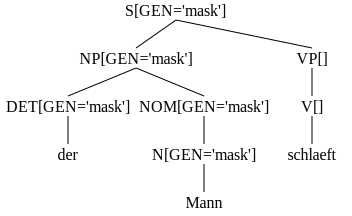

no parse found for: das Mann schlaeft


In [579]:
parser = nltk.FeatureChartParser(grammar)
for sent in pos_neg_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, style=1) for tree in trees]
    else: print(f"no parse found for: {sent}")

#### Optional können Sie auch folgende NP-Grammatik, die die Features aus der Tabelle oben enthält, um syntaktische Constraints erweitern und testen:

In [580]:
grammar = FeatureGrammar.fromstring(r"""
                                    
NP[AGR=?a] -> DET[AGR=?a] NOM[AGR=?a]
NOM[AGR=?a] -> N[AGR=?a]

DET[AGR=[NUM=sg, GEN=mask, CASE=nom]] -> "der"
DET[AGR=[NUM=sg, GEN=fem, CASE=dat]] -> "der"
DET[AGR=[NUM=sg, GEN=fem, CASE=gen]] -> "der"
DET[AGR=[NUM=pl, CASE=gen]] -> "der"

DET[AGR=[NUM=sg, GEN=fem, CASE=nom]] -> "die"
DET[AGR=[NUM=sg, GEN=fem, CASE=akk]] -> "die"
DET[AGR=[NUM=pl, CASE=nom]] -> "die"
DET[AGR=[NUM=pl, CASE=akk]] -> "die"

DET[AGR=[NUM=sg, GEN=neut, CASE=nom]] -> "das"
DET[AGR=[NUM=sg, GEN=neut, CASE=akk]] -> "das"

N[AGR=[NUM=sg, GEN=mask, CASE=nom]] -> "Mann"
N[AGR=[NUM=sg, GEN=fem, CASE=nom]] -> "Frau"
N[AGR=[NUM=sg, GEN=neut, CASE=nom]] -> "Buch"
""")

In [581]:
pos_sg_NPs = ["der Mann", "der Frau", "die Frau", "das Buch"]
neg_sg_NPs = ["das Mann", "die Mann", "das Frau", "der Buch", "die Buch"]

In [582]:
parser = nltk.FeatureChartParser(grammar)
for sent in neg_sg_NPs:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, draw=0) for tree in trees]
    else: print(f"no parse found for: {sent}")

no parse found for: das Mann
no parse found for: die Mann
no parse found for: das Frau
no parse found for: der Buch
no parse found for: die Buch


In [583]:
parser = nltk.FeatureChartParser(grammar)
for sent in pos_sg_NPs:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, draw=0) for tree in trees]
    else: print(f"no parse found for: {sent}")

FOUND PARSE:
 (NP[AGR=[CASE='nom', GEN='mask', NUM='sg']]   (DET[AGR=[CASE='nom', GEN='mask', NUM='sg']] der)   (NOM[AGR=[CASE='nom', GEN='mask', NUM='sg']]     (N[AGR=[CASE='nom', GEN='mask', NUM='sg']] Mann)))
no parse found for: der Frau
FOUND PARSE:
 (NP[AGR=[CASE='nom', GEN='fem', NUM='sg']]   (DET[AGR=[CASE='nom', GEN='fem', NUM='sg']] die)   (NOM[AGR=[CASE='nom', GEN='fem', NUM='sg']]     (N[AGR=[CASE='nom', GEN='fem', NUM='sg']] Frau)))
FOUND PARSE:
 (NP[AGR=[CASE='nom', GEN='neut', NUM='sg']]   (DET[AGR=[CASE='nom', GEN='neut', NUM='sg']] das)   (NOM[AGR=[CASE='nom', GEN='neut', NUM='sg']]     (N[AGR=[CASE='nom', GEN='neut', NUM='sg']] Buch)))


### b) Kasus und Subkategorisierung

#### Als nächstes sollen Kasusbedingungen in die Grammatik integriert werden (fügen Sie ggf. neue lexikalische Regeln für die Beispielsätze hinzu):

1. Es gibt nur eine Nominalphrase im Nominativ (Subjekt).
1. Je nach Valenzstellen des Verbes sollen nur Nominalphrasen in den korrekten Kasus akzeptiert werden.
1. *Optional:* Versuchen Sie die freie Satzstellung des Deutschen zu berücksichtigen. (Sie können dazu die VP-Struktur auflösen, also flachere Satzregeln verwenden, und ein zusätzliches SBJCASE-Merkmal verwenden.)

In [584]:
pos_sents = [   
    "das Buch gefaellt der Frau",
    "das Buch kennt die Frau",
    "der Mann gibt der Frau das Buch"
]

neg_sents = [
    "das Mann schlaeft",
    "der Mann schlaeft das Buch",  #Verletzung Subkategorisierung-Constraint
    "die Frau gefaellt das Buch",  #Verletzung Objektkasus-Constraint
    "den Mann schlaeft",  #Verletzung Subjektkasus-Constraint
    "die Frau gibt das Buch"  #Verletzung Subkategorisierung-Constraint
]

In [585]:
grammar = FeatureGrammar.fromstring(r"""
    S -> NP[CASE=nom] VP

    NP[GEN=?g, CASE=?c] -> DET[GEN=?g, CASE=?c] NOM[GEN=?g, CASE=?c]
    NOM[GEN=?g, CASE=?c] -> N[GEN=?g, CASE=?c]
    VP -> V[SUBCAT=2] NP[CASE=dat] NP[CASE=akk]
    VP -> V[SUBCAT=1] NP[CASE=akk]
    VP -> V[SUBCAT=0]
    VP -> V[SUBCAT=datverb] NP[CASE=dat]
    

    # Determiners with Case and Gender
    DET[CASE=nom, GEN=mask] -> "der"
    DET[CASE=akk, GEN=mask] -> "den"
    DET[CASE=dat, GEN=mask] -> "dem"

    DET[CASE=nom, GEN=fem] -> "die"
    DET[CASE=akk, GEN=fem] -> "die"
    DET[CASE=dat, GEN=fem] -> "der"

    DET[CASE=nom, GEN=neut] -> "das"
    DET[CASE=akk, GEN=neut] -> "das"
    DET[CASE=dat, GEN=neut] -> "dem"
    
    # Nouns with Case and Gender
    N[CASE=nom, GEN=mask] -> "Mann"
    N[CASE=akk, GEN=mask] -> "Mann"
    N[CASE=dat, GEN=mask] -> "Mann"

    N[CASE=nom, GEN=fem] -> "Frau"
    N[CASE=akk, GEN=fem] -> "Frau"
    N[CASE=dat, GEN=fem] -> "Frau"

    N[CASE=nom, GEN=neut] -> "Buch"
    N[CASE=akk, GEN=neut] -> "Buch"
    N[CASE=dat, GEN=neut] -> "Buch"
    
    # Verbs with Subcategorization
    V[SUBCAT=0] -> "schlaeft"
    V[SUBCAT=1] -> "kennt"
    V[SUBCAT=2] -> "gibt" | "schenkt"
    V[SUBCAT=datverb] -> "gefaellt"

    # Special rule for verbs like "gefaellt" that take a dative subject
    S -> NP[CASE=dat] VP[SUBCAT=datverb] NP[CASE=nom]
""")

parser = nltk.FeatureChartParser(grammar)

In [586]:
for sent in neg_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, style=1) for tree in trees]
    else: print(f"no parse found for: {sent}")

no parse found for: das Mann schlaeft
no parse found for: der Mann schlaeft das Buch
no parse found for: die Frau gefaellt das Buch
no parse found for: den Mann schlaeft
no parse found for: die Frau gibt das Buch


In [587]:
for sent in pos_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, style=1, draw=0) for tree in trees]
    else: print(f"no parse found for: {sent}")

FOUND PARSE:
 (S[]   (NP[CASE='nom', GEN='neut']     (DET[CASE='nom', GEN='neut'] das)     (NOM[CASE='nom', GEN='neut'] (N[CASE='nom', GEN='neut'] Buch)))   (VP[]     (V[SUBCAT='datverb'] gefaellt)     (NP[CASE='dat', GEN='fem']       (DET[CASE='dat', GEN='fem'] der)       (NOM[CASE='dat', GEN='fem'] (N[CASE='dat', GEN='fem'] Frau)))))
FOUND PARSE:
 (S[]   (NP[CASE='nom', GEN='neut']     (DET[CASE='nom', GEN='neut'] das)     (NOM[CASE='nom', GEN='neut'] (N[CASE='nom', GEN='neut'] Buch)))   (VP[]     (V[SUBCAT=1] kennt)     (NP[CASE='akk', GEN='fem']       (DET[CASE='akk', GEN='fem'] die)       (NOM[CASE='akk', GEN='fem'] (N[CASE='akk', GEN='fem'] Frau)))))
FOUND PARSE:
 (S[]   (NP[CASE='nom', GEN='mask']     (DET[CASE='nom', GEN='mask'] der)     (NOM[CASE='nom', GEN='mask'] (N[CASE='nom', GEN='mask'] Mann)))   (VP[]     (V[SUBCAT=2] gibt)     (NP[CASE='dat', GEN='fem']       (DET[CASE='dat', GEN='fem'] der)       (NOM[CASE='dat', GEN='fem'] (N[CASE='dat', GEN='fem'] Frau)))     (NP[CAS

#### Testsätze für invertierte Wortstellung (Bedingung 3):

In [588]:
pos_inv_sents = [
    "den Mann kennt die Frau",
    "die Frau kennt der Mann",
    "der Frau gibt der Mann das Buch",
    "das Buch gibt der Mann der Frau"
]

In [589]:
for sent in pos_inv_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, style=1, draw=0) for tree in trees]
    else: print(f"no parse found for: {sent}")

no parse found for: den Mann kennt die Frau
no parse found for: die Frau kennt der Mann
no parse found for: der Frau gibt der Mann das Buch
no parse found for: das Buch gibt der Mann der Frau


### c) Kasus und Subkategorisierung mit Slash-Kategorie

#### Wiederholen Sie die Modellierung für Kasusbedingungen über ein INV-Feature für die invertierte VP bei transitiven Verben und eines Gap-Features (Slash-Kategorie) für die an das Satzende gestellte Objekt-NP.


In [590]:
grammar = FeatureGrammar.fromstring(r"""

# Main Sentence Rules
S[SLASH=?s] -> NP[CASE=nom] VP[SLASH=?s]
S[SLASH=[NP[CASE=akk]]] -> NP[CASE=akk] VP[SLASH=[]]
S[SLASH=[], SUBCAT=datverb] -> NP[CASE=dat] VP[SUBCAT=datverb, SLASH=[]] NP[CASE=nom]

# VP Rules (Fix for Ditransitive Verbs)
VP[SUBCAT=2, SLASH=?s] -> V[SUBCAT=2] NP[CASE=dat] NP[CASE=akk]
VP[SUBCAT=1, SLASH=?s] -> V[SUBCAT=1] NP[CASE=akk]
VP[SUBCAT=0, SLASH=?s] -> V[SUBCAT=0]
VP[SUBCAT=datverb, SLASH=?s] -> V[SUBCAT=datverb] NP[CASE=dat]

# Handling Object Movement (Slash Feature)
VP[INV='+', SLASH=?s] -> V[SUBCAT=1] NP[CASE=akk]
VP[INV='-', SLASH=[NP[CASE=akk]]] -> V[SUBCAT=1] NP[SLASH=[NP[CASE=akk]]]

# NP Definitions
NP[GEN=?g, CASE=?c] -> DET[GEN=?g, CASE=?c] NOM[GEN=?g, CASE=?c]
NOM[GEN=?g, CASE=?c] -> N[GEN=?g, CASE=?c]
NP[SLASH=[NP[CASE=akk]]] -> []

# Determiners
DET[CASE=nom, GEN=mask] -> "der"
DET[CASE=akk, GEN=mask] -> "den"
DET[CASE=dat, GEN=mask] -> "dem"
DET[CASE=nom, GEN=fem] -> "die"
DET[CASE=akk, GEN=fem] -> "die"
DET[CASE=dat, GEN=fem] -> "der"
DET[CASE=nom, GEN=neut] -> "das"
DET[CASE=akk, GEN=neut] -> "das"
DET[CASE=dat, GEN=neut] -> "dem"

# Nouns
N[CASE=nom, GEN=mask] -> "Mann"
N[CASE=akk, GEN=mask] -> "Mann"
N[CASE=dat, GEN=mask] -> "Mann"
N[CASE=nom, GEN=fem] -> "Frau"
N[CASE=akk, GEN=fem] -> "Frau"
N[CASE=dat, GEN=fem] -> "Frau"
N[CASE=nom, GEN=neut] -> "Buch"
N[CASE=akk, GEN=neut] -> "Buch"
N[CASE=dat, GEN=neut] -> "Buch"

# Verbs
V[SUBCAT=0] -> "schlaeft"
V[SUBCAT=1] -> "kennt"
V[SUBCAT=2] -> "gibt" | "schenkt"
V[SUBCAT=datverb] -> "gefaellt"
""")
   
parser = nltk.FeatureChartParser(grammar)   

In [591]:
for sent in pos_inv_sents:
    trees = list(parser.parse(sent.split()))                       
    if trees: [show_FeatTree(tree, style=1, draw=0) for tree in trees]
    else: print(f"no parse found for: {sent}")

FOUND PARSE:
 (S[SLASH=[NP[CASE='akk']]]   (NP[CASE='akk', GEN='mask']     (DET[CASE='akk', GEN='mask'] den)     (NOM[CASE='akk', GEN='mask'] (N[CASE='akk', GEN='mask'] Mann)))   (VP[INV='+', SLASH=?s]     (V[SUBCAT=1] kennt)     (NP[CASE='akk', GEN='fem']       (DET[CASE='akk', GEN='fem'] die)       (NOM[CASE='akk', GEN='fem'] (N[CASE='akk', GEN='fem'] Frau)))))
FOUND PARSE:
 (S[SLASH=[NP[CASE='akk']]]   (NP[CASE='akk', GEN='mask']     (DET[CASE='akk', GEN='mask'] den)     (NOM[CASE='akk', GEN='mask'] (N[CASE='akk', GEN='mask'] Mann)))   (VP[SLASH=?s, SUBCAT=1]     (V[SUBCAT=1] kennt)     (NP[CASE='akk', GEN='fem']       (DET[CASE='akk', GEN='fem'] die)       (NOM[CASE='akk', GEN='fem'] (N[CASE='akk', GEN='fem'] Frau)))))
FOUND PARSE:
 (S[SLASH=[NP[CASE='akk']]]   (NP[CASE='nom', GEN='fem']     (DET[CASE='nom', GEN='fem'] die)     (NOM[CASE='nom', GEN='fem'] (N[CASE='nom', GEN='fem'] Frau)))   (VP[INV='-', SLASH=[NP[CASE='akk']]]     (V[SUBCAT=1] kennt)     (NP[CASE='nom', GEN='mask']

no parse found for: das Mann schlaeft
no parse found for: der Mann schlaeft das Buch
no parse found for: die Frau gefaellt das Buch


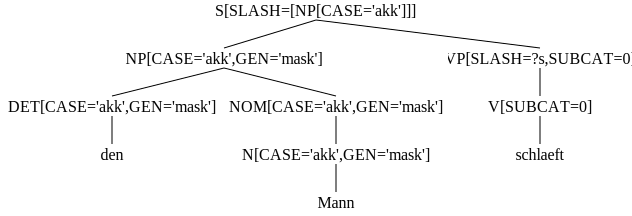

no parse found for: die Frau gibt das Buch


In [592]:
for sent in neg_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, style=1) for tree in trees]
    else: print(f"no parse found for: {sent}")

In [593]:
for sent in pos_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, style=1, draw=0) for tree in trees]
    else: print(f"no parse found for: {sent}")

FOUND PARSE:
 (S[SLASH=[NP[CASE='akk']]]   (NP[CASE='akk', GEN='neut']     (DET[CASE='akk', GEN='neut'] das)     (NOM[CASE='akk', GEN='neut'] (N[CASE='akk', GEN='neut'] Buch)))   (VP[SLASH=?s, SUBCAT='datverb']     (V[SUBCAT='datverb'] gefaellt)     (NP[CASE='dat', GEN='fem']       (DET[CASE='dat', GEN='fem'] der)       (NOM[CASE='dat', GEN='fem'] (N[CASE='dat', GEN='fem'] Frau)))))
FOUND PARSE:
 (S[SLASH=?s]   (NP[CASE='nom', GEN='neut']     (DET[CASE='nom', GEN='neut'] das)     (NOM[CASE='nom', GEN='neut'] (N[CASE='nom', GEN='neut'] Buch)))   (VP[SLASH=?s, SUBCAT='datverb']     (V[SUBCAT='datverb'] gefaellt)     (NP[CASE='dat', GEN='fem']       (DET[CASE='dat', GEN='fem'] der)       (NOM[CASE='dat', GEN='fem'] (N[CASE='dat', GEN='fem'] Frau)))))
FOUND PARSE:
 (S[SLASH=[NP[CASE='akk']]]   (NP[CASE='nom', GEN='neut']     (DET[CASE='nom', GEN='neut'] das)     (NOM[CASE='nom', GEN='neut'] (N[CASE='nom', GEN='neut'] Buch)))   (VP[INV='-', SLASH=[NP[CASE='akk']]]     (V[SUBCAT=1] kennt)   

### d) Plural-Agreement für Subjekt und Verb

#### Ergänzen Sie die Grammatik aus b) um die Möglichkeit, das Subjekt in den Plural zu setzen.

#### Dafür müssen Sie folgendes tun:
  1. Erstellen Sie lexikalische Regeln für Pluralformen der Verben und Substantive (Nominativ ist ausreichend.).
  1. Vervollständigen Sie die lexikalischen Regeln für die Form des Artikels *die* um die korrekte Merkmalstruktur für den Plural.
  1. Formulieren Sie eine Kongruenzbedingung in Numerus zwischen Verb und Subjekt.

In [594]:
pos_sents = [   
    "das Buch gefaellt der Frau",
    "das Buch kennt die Frau",
    "der Mann gibt der Frau das Buch",
    
    "die Maenner geben der Frau das Buch",
    "die Bücher gefallen der Frau",
    "die Frauen schlafen"
]

neg_sents = [
    "das Mann schlaeft",
    "der Mann schlaeft das Buch",
    "die Frau gefaellt das Buch",
    "den Mann schlaeft",
    "die Frau gibt das Buch",
    
    "der Mann geben der Frau das Buch",
    "das Buch gefaellt der Frauen",
    "die Frauen schlaeft"
]

In [595]:
grammar = FeatureGrammar.fromstring(r"""

# Main Sentence Rules
S[SLASH=?s, NUM=?num] -> NP[CASE=nom, NUM=?num] VP[SLASH=?s, NUM=?num]
S[SLASH=[NP[CASE=akk]]] -> NP[CASE=akk, NUM=?num] VP[SLASH=[], NUM=?num]
S[SLASH=[], SUBCAT=datverb] -> NP[CASE=dat, NUM=?num] VP[SUBCAT=datverb, SLASH=[], NUM=?num] NP[CASE=nom, NUM=?num]

# VP Rules (Fix for Ditransitive Verbs)
VP[SUBCAT=2, SLASH=?s, NUM=?num] -> V[SUBCAT=2, NUM=?num] NP[CASE=dat, NUM=?num] NP[CASE=akk, NUM=?num]
VP[SUBCAT=2, SLASH=[NP[CASE=akk]], NUM=?num] -> V[SUBCAT=2, NUM=?num] NP[CASE=dat, NUM=?num] NP[SLASH=[NP[CASE=akk]]]
VP[SUBCAT=1, SLASH=?s, NUM=?num] -> V[SUBCAT=1, NUM=?num] NP[CASE=akk, NUM=?num]
VP[SUBCAT=0, SLASH=?s, NUM=?num] -> V[SUBCAT=0, NUM=?num]
VP[SUBCAT=datverb, SLASH=?s, NUM=?num] -> V[SUBCAT=datverb, NUM=?num] NP[CASE=dat, NUM=?num]

# Handling Object Movement (Slash Feature)
VP[INV='+', SLASH=?s, NUM=?num] -> V[SUBCAT=1, NUM=?num] NP[CASE=akk, NUM=?num]
VP[INV='-', SLASH=[NP[CASE=akk]], NUM=?num] -> V[SUBCAT=1, NUM=?num] NP[SLASH=[NP[CASE=akk]]]

# NP Definitions
NP[GEN=?g, CASE=?c, NUM=?num] -> DET[GEN=?g, CASE=?c, NUM=?num] NOM[GEN=?g, CASE=?c, NUM=?num]
NOM[GEN=?g, CASE=?c, NUM=?num] -> N[GEN=?g, CASE=?c, NUM=?num]
NP[SLASH=[NP[CASE=akk]]] -> []

# Determiners
DET[CASE=nom, GEN=mask, NUM=sg] -> "der"
DET[CASE=akk, GEN=mask, NUM=sg] -> "den"
DET[CASE=dat, GEN=mask, NUM=sg] -> "dem"
DET[CASE=nom, GEN=fem, NUM=sg] -> "die"
DET[CASE=akk, GEN=fem, NUM=sg] -> "die"
DET[CASE=dat, GEN=fem, NUM=sg] -> "der"
DET[CASE=nom, GEN=neut, NUM=sg] -> "das"
DET[CASE=akk, GEN=neut, NUM=sg] -> "das"
DET[CASE=dat, GEN=neut, NUM=sg] -> "dem"
DET[CASE=nom, NUM=pl] -> "die"
DET[CASE=akk, NUM=pl] -> "die"
DET[CASE=dat, NUM=pl] -> "den"

# Nouns
N[CASE=nom, GEN=mask, NUM=sg] -> "Mann"
N[CASE=akk, GEN=mask, NUM=sg] -> "Mann"
N[CASE=dat, GEN=mask, NUM=sg] -> "Mann"
N[CASE=nom, GEN=fem, NUM=sg] -> "Frau"
N[CASE=akk, GEN=fem, NUM=sg] -> "Frau"
N[CASE=dat, GEN=fem, NUM=sg] -> "Frau"
N[CASE=nom, GEN=neut, NUM=sg] -> "Buch"
N[CASE=akk, GEN=neut, NUM=sg] -> "Buch"
N[CASE=dat, GEN=neut, NUM=sg] -> "Buch"
N[CASE=nom, GEN=mask, NUM=pl] -> "Maenner"
N[CASE=nom, GEN=fem, NUM=pl] -> "Frauen"
N[CASE=nom, GEN=neut, NUM=pl] -> "Bücher"

# Verbs
V[SUBCAT=0, NUM=sg] -> "schlaeft"
V[SUBCAT=0, NUM=pl] -> "schlafen"
V[SUBCAT=1, NUM=sg] -> "kennt"
V[SUBCAT=2, NUM=sg] -> "gibt" | "schenkt"
V[SUBCAT=2, NUM=pl] -> "geben"
V[SUBCAT=datverb, NUM=sg] -> "gefaellt"
V[SUBCAT=datverb, NUM=pl] -> "gefallen"
""")
   
parser = nltk.FeatureChartParser(grammar)   

no parse found for: das Mann schlaeft
no parse found for: der Mann schlaeft das Buch
no parse found for: die Frau gefaellt das Buch


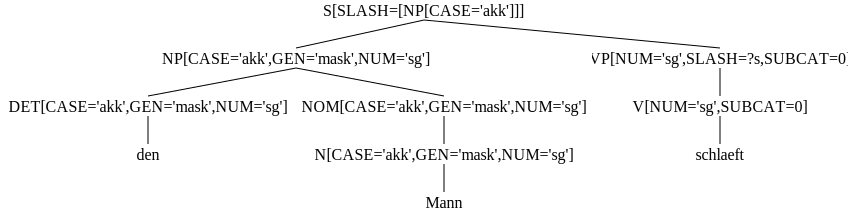

no parse found for: die Frau gibt das Buch
no parse found for: der Mann geben der Frau das Buch
no parse found for: das Buch gefaellt der Frauen
no parse found for: die Frauen schlaeft


In [596]:
for sent in neg_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, style=1) for tree in trees]
    else: print(f"no parse found for: {sent}")

In [597]:
for sent in pos_sents:
    trees = list(parser.parse(sent.split()))
    if trees: [show_FeatTree(tree, style=1, draw=0) for tree in trees]
    else: print(f"no parse found for: {sent}")

FOUND PARSE:
 (S[SLASH=[NP[CASE='akk']]]   (NP[CASE='akk', GEN='neut', NUM='sg']     (DET[CASE='akk', GEN='neut', NUM='sg'] das)     (NOM[CASE='akk', GEN='neut', NUM='sg']       (N[CASE='akk', GEN='neut', NUM='sg'] Buch)))   (VP[NUM='sg', SLASH=?s, SUBCAT='datverb']     (V[NUM='sg', SUBCAT='datverb'] gefaellt)     (NP[CASE='dat', GEN='fem', NUM='sg']       (DET[CASE='dat', GEN='fem', NUM='sg'] der)       (NOM[CASE='dat', GEN='fem', NUM='sg']         (N[CASE='dat', GEN='fem', NUM='sg'] Frau)))))
FOUND PARSE:
 (S[NUM='sg', SLASH=?s]   (NP[CASE='nom', GEN='neut', NUM='sg']     (DET[CASE='nom', GEN='neut', NUM='sg'] das)     (NOM[CASE='nom', GEN='neut', NUM='sg']       (N[CASE='nom', GEN='neut', NUM='sg'] Buch)))   (VP[NUM='sg', SLASH=?s, SUBCAT='datverb']     (V[NUM='sg', SUBCAT='datverb'] gefaellt)     (NP[CASE='dat', GEN='fem', NUM='sg']       (DET[CASE='dat', GEN='fem', NUM='sg'] der)       (NOM[CASE='dat', GEN='fem', NUM='sg']         (N[CASE='dat', GEN='fem', NUM='sg'] Frau)))))
FOUN